In [85]:
# mount drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
import pandas as pd

# Read the ESP32 log file
with open('/path/to/file', 'r') as file:
    lines = file.readlines()

# Initialize a list to hold the cleaned data
data = []

# Process each line
for line in lines:
    parts = line.strip().split(' - ')
    if len(parts) == 2:
        timestamp, log_entry = parts
        data.append({'timestamp': timestamp, 'log_entry': log_entry})

# Convert to DataFrame
df = pd.DataFrame(data)

# Save to CSV
df.to_csv('outside_esp32_log_cleaned.csv', index=False)

print("ESP32 log processed and saved.")


ESP32 log processed and saved.


In [87]:
import pandas as pd
from datetime import datetime

def process_ping_file(file_path):
    # Read the ping results file
    with open(file_path, 'r') as file:
        lines = file.readlines()

    # Initialize a list to hold the cleaned data
    data = []
    current_timestamp = None

    # Process each line
    for line in lines:
        # Detect timestamp line (e.g., "Pinging 172.20.10.6 at Sat 14 Dec 21:01:27 GMT 2024")
        if line.startswith("Pinging"):
            parts = line.split(" at ")
            if len(parts) > 1:
                timestamp_str = parts[1].strip()
                current_timestamp = datetime.strptime(timestamp_str, "%a %d %b %H:%M:%S GMT %Y")
            continue

        # Process lines with ping data (e.g., "64 bytes from 172.20.10.6: icmp_seq=1 ttl=64 time=12.0 ms")
        if "bytes from" in line:
            parts = line.split()
            seq = parts[4].split('=')[1]  # Extract sequence number
            ttl = parts[5].split('=')[1]  # Extract TTL
            time = parts[6].split('=')[1]  # Extract time (e.g., "12.0 ms")
            time_value = float(time[:-2])  # Remove "ms" and convert to float

            # Append the data with the current timestamp
            data.append({
                'timestamp': current_timestamp.strftime('%Y-%m-%d %H:%M:%S') if current_timestamp else None,
                'seq': int(seq),
                'ttl': int(ttl),
                'time_ms': time_value
            })

    return data

# File paths to the ping results
file_path_1 = '/path/to/file'
file_path_2 = '/path/to/file'

# Process the ping files
ping_data_1 = process_ping_file(file_path_1)
ping_data_2 = process_ping_file(file_path_2)

# Convert to DataFrame
df_ping_1 = pd.DataFrame(ping_data_1)
df_ping_2 = pd.DataFrame(ping_data_2)

# Save to CSV
output_path_1 = 'outside_ping_base_results_cleaned.csv'
output_path_2 = 'outside_ping_pi_results_cleaned.csv'
df_ping_1.to_csv(output_path_1, index=False)
df_ping_2.to_csv(output_path_2, index=False)

print(f"Ping results processed and saved to {output_path_1}.")
print(f"Ping results processed and saved to {output_path_2}.")


Ping results processed and saved to outside_ping_base_results_cleaned.csv.
Ping results processed and saved to outside_ping_pi_results_cleaned.csv.


In [88]:
import pandas as pd
from datetime import datetime, timedelta

# Path to the iperf3 results file
file_path = '/path/to/file'

# Read the file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Initialize variables
data = []
summary_data = []
entry = {}
start_time = None

# Conversion factors
CONVERSION_FACTORS = {
    'Bytes': 1 / 1024,       # Bytes to kBytes
    'KBytes': 1,            # kBytes stays the same
    'MBytes': 1024,         # MBytes to kBytes
    'Bits/sec': 1 / 1024,   # Bits/sec to kBits/sec
    'Kbits/sec': 1,         # kBits/sec stays the same
    'Mbits/sec': 1024       # Mbits/sec to kBits/sec
}

def extract_and_convert(value_with_unit, target_unit):
    """Extract value and unit from a string and convert to target unit."""
    if value_with_unit:
        value, unit = value_with_unit.split()
        value = float(value)
        if unit in CONVERSION_FACTORS:
            return value * CONVERSION_FACTORS[unit]
    return None

# Process each line
for line in lines:
    # Detect start time from "Running iperf3 test at ..." lines
    if line.startswith("Running iperf3 test at"):
        full_start_time = line.replace("Running iperf3 test at ", "").strip()
        # Extract only the time portion (hh:mm:ss)
        parsed_start_time = datetime.strptime(full_start_time, "%a %d %b %H:%M:%S GMT %Y")
        start_time = parsed_start_time.time()
        continue

    # Detect summary statistics rows
    if 'sender' in line or 'receiver' in line:
        parts = line.split()
        summary_entry = {
            'timestamp': parsed_start_time.strftime('%H:%M:%S'),  # Add full start time as a timestamp
            'role': 'sender' if 'sender' in line else 'receiver',
            'interval': parts[2],  # e.g., "0.00-10.00"
            'transfer': float(extract_and_convert(parts[4] + " " + parts[5], 'Kbytes')),
            'bitrate': float(extract_and_convert(parts[6] + " " + parts[7], 'Kbytes/sec')),
            'retr': int(parts[8]) if 'sender' in line else None,  # 'retr' exists only for the sender
        }
        summary_data.append(summary_entry)
        continue

    # Capture data lines containing iperf3 output
    if 'sec' in line and ('MBytes' in line or 'Bytes' in line) and 'Mbits/sec' in line:
        parts = line.split()
        if len(parts) >= 11:  # Full data line with cwnd
            interval = parts[2]  # e.g., "0.00-1.00"
            start_seconds = int(float(interval.split('-')[0]))  # Start of the interval in seconds
            timestamp = (datetime.combine(datetime.today(), start_time) + timedelta(seconds=start_seconds)).strftime('%H:%M:%S')

            entry.update({
                'timestamp': timestamp,
                'transfer': float(extract_and_convert(parts[4] + " " + parts[5], 'Kbytes')),
                'bitrate': float(extract_and_convert(parts[6] + " " + parts[7], 'Kbytes/sec')),
                'retr': int(parts[8]),
                'cwnd': int(extract_and_convert(parts[9] + " " + parts[10], 'Kbytes')), # Isolate the numerical value from cwnd
            })
        data.append(entry)
        entry = {}

# Convert to DataFrames
df_detailed = pd.DataFrame(data)
df_summary = pd.DataFrame(summary_data)

# Save the cleaned data to CSV files
output_path_detailed = 'outside_iperf3_results_detailed.csv'
output_path_summary = 'outside_iperf3_results_summary.csv'
df_detailed.to_csv(output_path_detailed, index=False)
df_summary.to_csv(output_path_summary, index=False)

print(f"Detailed results saved to {output_path_detailed}.")
print(f"Summary statistics saved to {output_path_summary}.")

Detailed results saved to outside_iperf3_results_detailed.csv.
Summary statistics saved to outside_iperf3_results_summary.csv.


<ipython-input-2-972c288fc369>:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
<ipython-input-2-972c288fc369>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])
<ipython-input-2-972c288fc369>:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  bin_edges = pd.date_range(start=df_filtered['timestamp'].min(), end=df_filtered['timestamp'].max(), freq='10S')


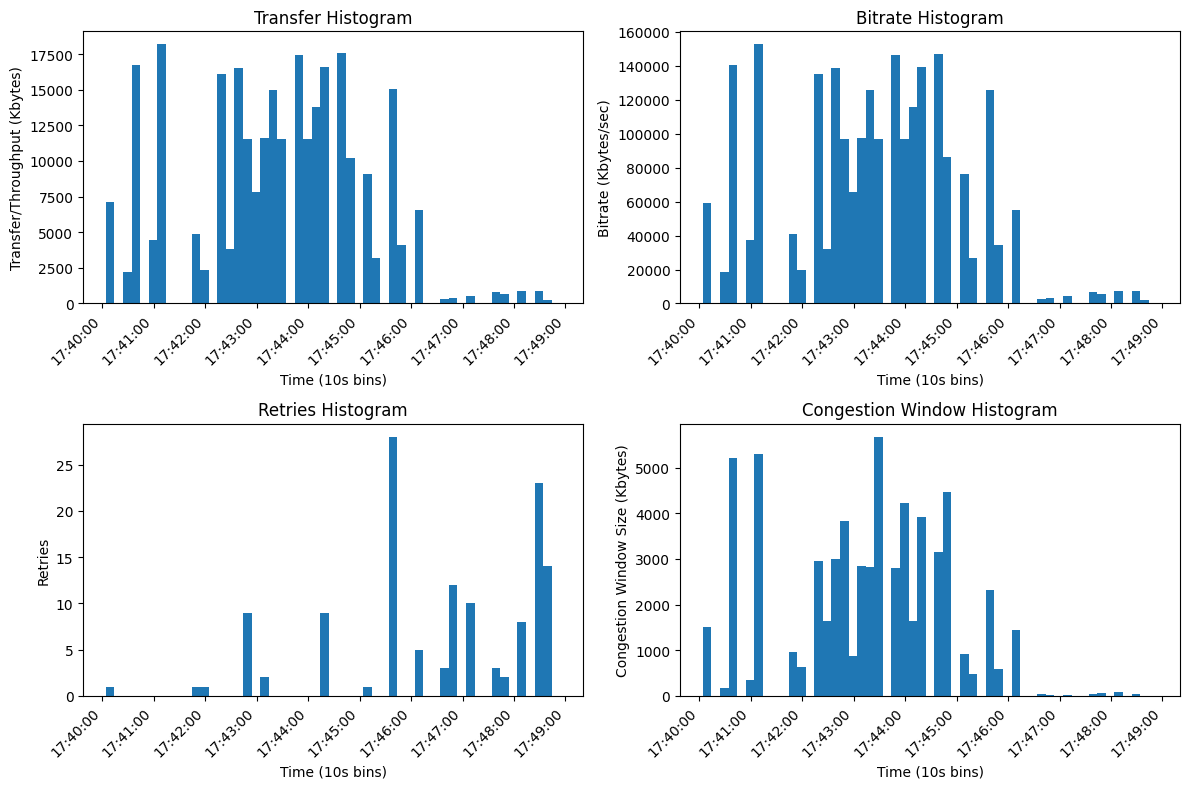

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the iperf3 detailed data
df_detailed = pd.read_csv('outside_iperf3_results_detailed.csv')

# Filter data for the 21st hour
df_filtered = df_detailed[df_detailed['timestamp'].str.startswith('17:')]

# Convert timestamp to datetime objects for binning
df_filtered['timestamp'] = pd.to_datetime(df_filtered['timestamp'])

# Filter data between 21:04:00 and 21:10:00
start_time = pd.to_datetime('17:21:00').time()
end_time = pd.to_datetime('17:40:00').time()
df_filtered = df_filtered[(df_filtered['timestamp'].dt.time >= start_time) & (df_filtered['timestamp'].dt.time <= end_time)]

# Define bin edges for 10-second intervals
bin_edges = pd.date_range(start=df_filtered['timestamp'].min(), end=df_filtered['timestamp'].max(), freq='10S')

# Create histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # 2x2 grid for 4 plots

# Histogram for transfer
axes[0, 0].hist(df_filtered['timestamp'], bins=bin_edges, weights=df_filtered['transfer'])
axes[0, 0].set_xlabel('Time (10s bins)')
axes[0, 0].set_ylabel('Transfer/Throughput (Kbytes)')
axes[0, 0].set_title('Transfer Histogram')

# Histogram for bitrate
axes[0, 1].hist(df_filtered['timestamp'], bins=bin_edges, weights=df_filtered['bitrate'])
axes[0, 1].set_xlabel('Time (10s bins)')
axes[0, 1].set_ylabel('Bitrate (Kbytes/sec)')
axes[0, 1].set_title('Bitrate Histogram')

# Histogram for retr
axes[1, 0].hist(df_filtered['timestamp'], bins=bin_edges, weights=df_filtered['retr'])
axes[1, 0].set_xlabel('Time (10s bins)')
axes[1, 0].set_ylabel('Retries')
axes[1, 0].set_title('Retries Histogram')

# Histogram for cwnd
axes[1, 1].hist(df_filtered['timestamp'], bins=bin_edges, weights=df_filtered['cwnd'])
axes[1, 1].set_xlabel('Time (10s bins)')
axes[1, 1].set_ylabel('Congestion Window Size (Kbytes)')
axes[1, 1].set_title('Congestion Window Histogram')


# Add more tick marks
for ax in axes.flat:
    # Set x-axis ticks to 1-minute intervals
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))
    # Format x-axis tick labels as HH:MM:SS
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    # Rotate x-axis tick labels for better readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()  # Adjust spacing between plots
plt.show()

<ipython-input-24-38b915688887>:9: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_summary['timestamp'] = pd.to_datetime(df_summary['timestamp'])
<ipython-input-24-38b915688887>:17: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  bin_edges = pd.date_range(start=filtered_df['timestamp'].min(), end=filtered_df['timestamp'].max(), freq='10S')


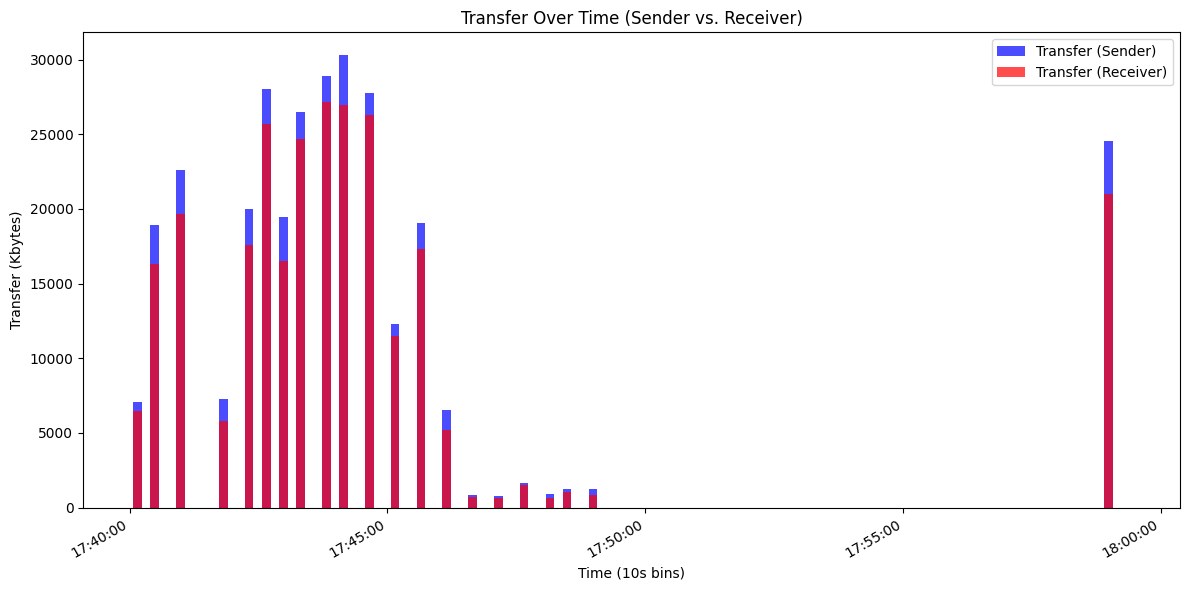

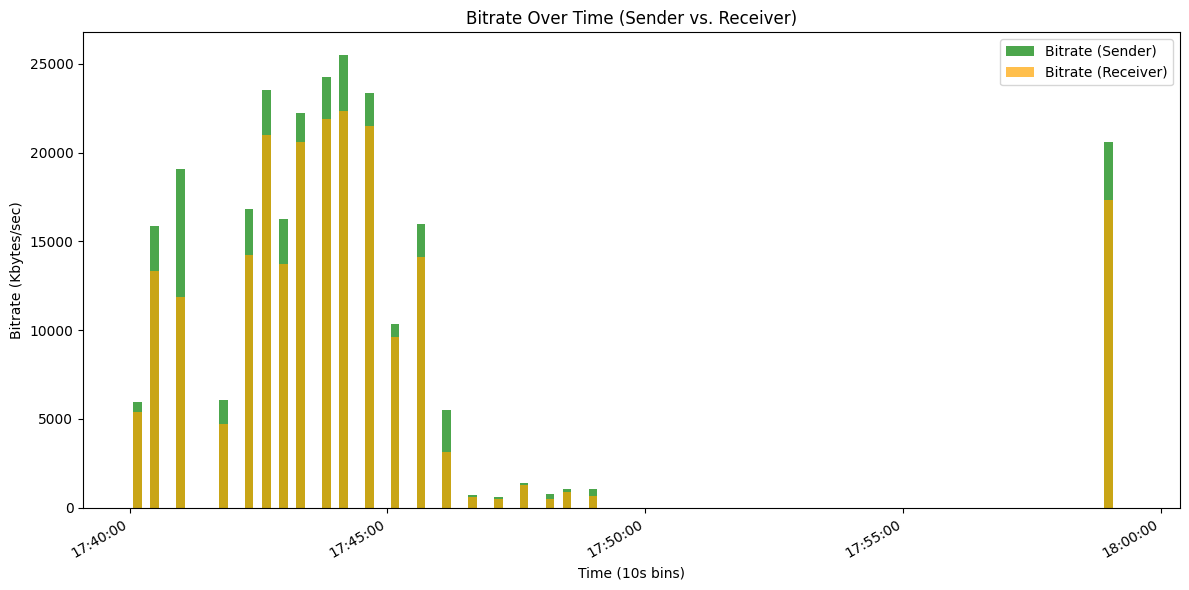

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the iperf3 summary data
df_summary = pd.read_csv('outside_iperf3_results_summary.csv')

# Convert 'timestamp' to datetime objects
df_summary['timestamp'] = pd.to_datetime(df_summary['timestamp'])

# Filter data between 17:21:00 and 17:40:00
start_time = pd.to_datetime('17:40:00').time()
end_time = pd.to_datetime('18:01:00').time()
filtered_df = df_summary[(df_summary['timestamp'].dt.time >= start_time) & (df_summary['timestamp'].dt.time <= end_time)]

# Define bin edges for 10-second intervals
bin_edges = pd.date_range(start=filtered_df['timestamp'].min(), end=filtered_df['timestamp'].max(), freq='10S')

# Create the first histogram for Transfer
plt.figure(figsize=(12, 6))
plt.hist(filtered_df[filtered_df['role'] == 'sender']['timestamp'], bins=bin_edges, weights=filtered_df[filtered_df['role'] == 'sender']['transfer'], label='Transfer (Sender)', alpha=0.7, color='blue')
plt.hist(filtered_df[filtered_df['role'] == 'receiver']['timestamp'], bins=bin_edges, weights=filtered_df[filtered_df['role'] == 'receiver']['transfer'], label='Transfer (Receiver)', alpha=0.7, color='red')
plt.xlabel('Time (10s bins)')
plt.ylabel('Transfer (Kbytes)')
plt.title('Transfer Over Time (Sender vs. Receiver)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

# Create the second histogram for Bitrate
plt.figure(figsize=(12, 6))
plt.hist(filtered_df[filtered_df['role'] == 'sender']['timestamp'], bins=bin_edges, weights=filtered_df[filtered_df['role'] == 'sender']['bitrate'], label='Bitrate (Sender)', alpha=0.7, color='green')
plt.hist(filtered_df[filtered_df['role'] == 'receiver']['timestamp'], bins=bin_edges, weights=filtered_df[filtered_df['role'] == 'receiver']['bitrate'], label='Bitrate (Receiver)', alpha=0.7, color='orange')
plt.xlabel('Time (10s bins)')
plt.ylabel('Bitrate (Kbytes/sec)')
plt.title('Bitrate Over Time (Sender vs. Receiver)')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.gcf().autofmt_xdate()
plt.legend()
plt.tight_layout()
plt.show()

<ipython-input-23-8317206aaa9e>:20: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  bin_edges = pd.date_range(start=df_ping_pi['timestamp'].min(), end=df_ping_pi['timestamp'].max(), freq='10S')


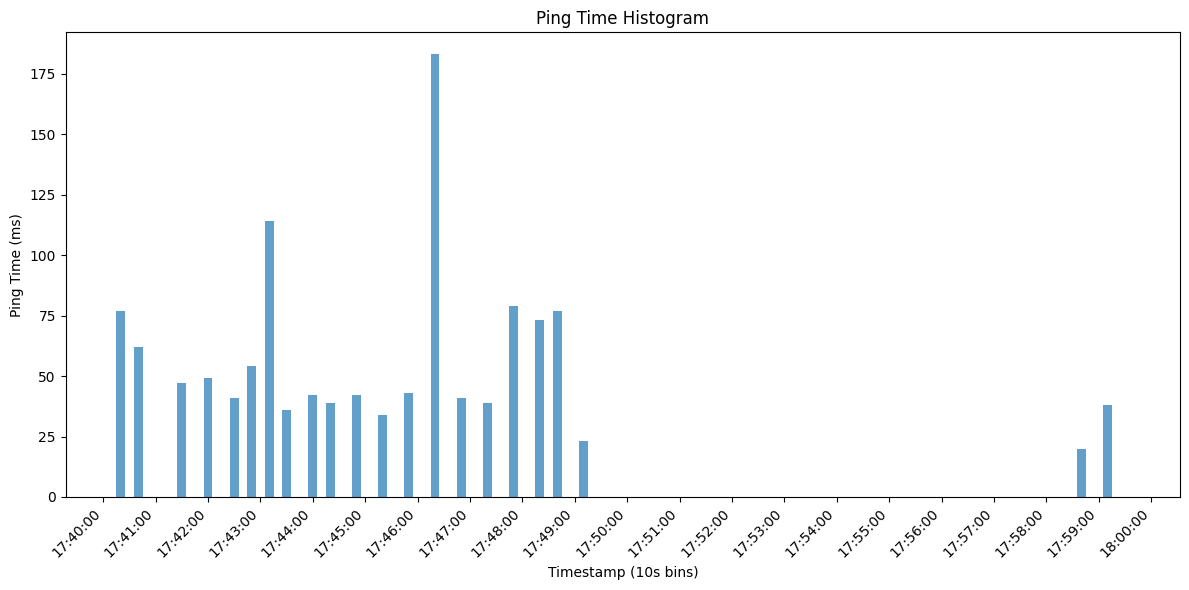

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load the ping data
df_ping_pi = pd.read_csv('outside_ping_pi_results_cleaned.csv')

# Filter data for the 21st hour
df_ping_pi = df_ping_pi[df_ping_pi['timestamp'].str.startswith('2024-12-15 17:')]

# Convert timestamp to datetime objects
df_ping_pi['timestamp'] = pd.to_datetime(df_ping_pi['timestamp'])

# Filter data between 21:04:00 and 21:10:00
start_time = pd.to_datetime('17:40:00').time()
end_time = pd.to_datetime('18:01:00').time()
df_ping_pi = df_ping_pi[(df_ping_pi['timestamp'].dt.time >= start_time) & (df_ping_pi['timestamp'].dt.time <= end_time)]

# Define bin edges for 10-second intervals
bin_edges = pd.date_range(start=df_ping_pi['timestamp'].min(), end=df_ping_pi['timestamp'].max(), freq='10S')

# Create the plot
fig, ax = plt.subplots(figsize=(12, 6))

# Plot histograms for ping time_ms for base and pi
ax.hist(df_ping_pi['timestamp'], bins=bin_edges, weights=df_ping_pi['time_ms'], label='Pi', alpha=0.7)

# Set labels and title
ax.set_xlabel('Timestamp (10s bins)')
ax.set_ylabel('Ping Time (ms)')
ax.set_title('Ping Time Histogram')

# Format x-axis ticks
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=1))  # 1-minute ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')


# Display the plot
plt.tight_layout()
plt.show()

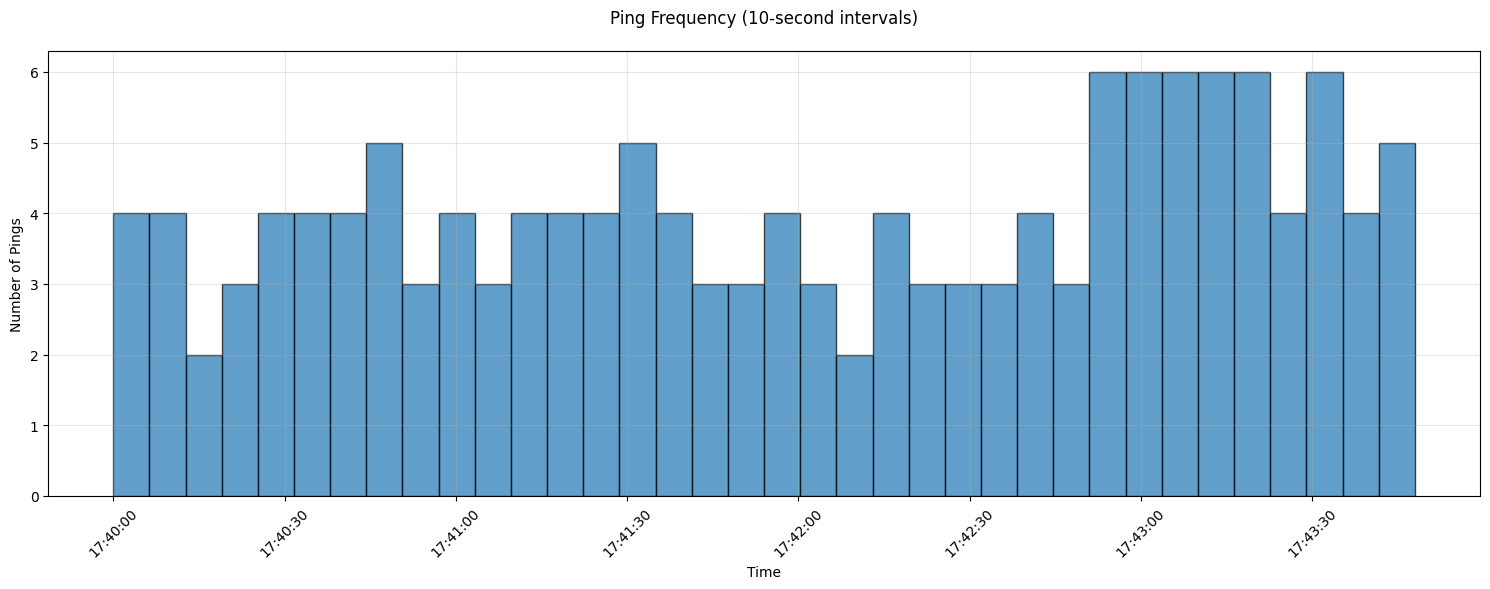

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Read the CSV data
df = pd.read_csv('outside_esp32_log_cleaned.csv')

# Convert timestamp strings to datetime objects
df['timestamp'] = pd.to_datetime(df['timestamp'], format='%Y-%m-%d: %H:%M:%S')

# Filter data for the specified time range
start_time = '2024-12-15 17:40:00'
end_time = '2024-12-15 18:01:00'
mask = (df['timestamp'] >= start_time) & (df['timestamp'] <= end_time)
filtered_df = df[mask]

# Create histogram
plt.figure(figsize=(15, 6))
plt.hist(filtered_df['timestamp'],
         bins=36,  # (6 minutes * 60 seconds) / 10 seconds per bin = 36 bins
         edgecolor='black',
         alpha=0.7)

# Customize the plot
plt.title('Ping Frequency (10-second intervals)', pad=20)
plt.xlabel('Time')
plt.ylabel('Number of Pings')

# Format x-axis to show only time
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%H:%M:%S'))
plt.xticks(rotation=45)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show grid for better readability
plt.grid(True, alpha=0.3)

plt.show()